<a href="https://colab.research.google.com/github/EskilRibbe11/Defensive-Distillation/blob/main/Defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5061689.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133441.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272389.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5985086.01it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    output = F.log_softmax(x, dim=1)
    return output

In [ ]:
model = Net().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [ ]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.16989231587872916 Val_Loss: 0.08594308333110093
Epoch: 2 Loss: 0.06524113115001581 Val_Loss: 0.07389244898119983
Epoch: 3 Loss: 0.049728719742030504 Val_Loss: 0.06624762607593197
Epoch: 4 Loss: 0.042318048158062505 Val_Loss: 0.05970770044374648
Epoch: 5 Loss: 0.03754287647133013 Val_Loss: 0.06885401145933265
Epoch: 6 Loss: 0.03411931001146955 Val_Loss: 0.05888428896747767
Epoch: 7 Loss: 0.030112463878140865 Val_Loss: 0.06115680730579436
Epoch: 8 Loss: 0.02814882327160959 Val_Loss: 0.05858224776576005
Epoch: 9 Loss: 0.025662050166769236 Val_Loss: 0.060184964720942605
Epoch: 10 Loss: 0.023632320477269323 Val_Loss: 0.05637127911446096


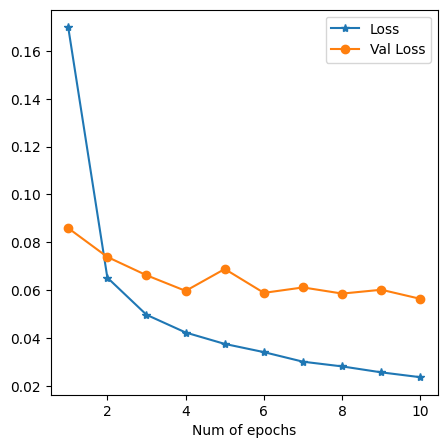

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [ ]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9834 / 10000 = 0.9834
Epsilon: 0.007	Test Accuracy = 9808 / 10000 = 0.9808
Epsilon: 0.01	Test Accuracy = 9792 / 10000 = 0.9792
Epsilon: 0.02	Test Accuracy = 9742 / 10000 = 0.9742
Epsilon: 0.03	Test Accuracy = 9649 / 10000 = 0.9649
Epsilon: 0.05	Test Accuracy = 9452 / 10000 = 0.9452
Epsilon: 0.1	Test Accuracy = 7960 / 10000 = 0.796
Epsilon: 0.2	Test Accuracy = 2545 / 10000 = 0.2545
Epsilon: 0.3	Test Accuracy = 1116 / 10000 = 0.1116


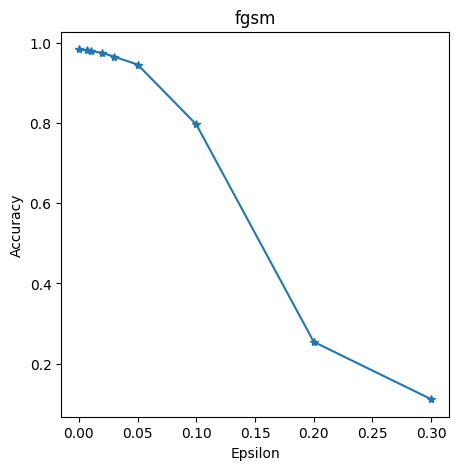

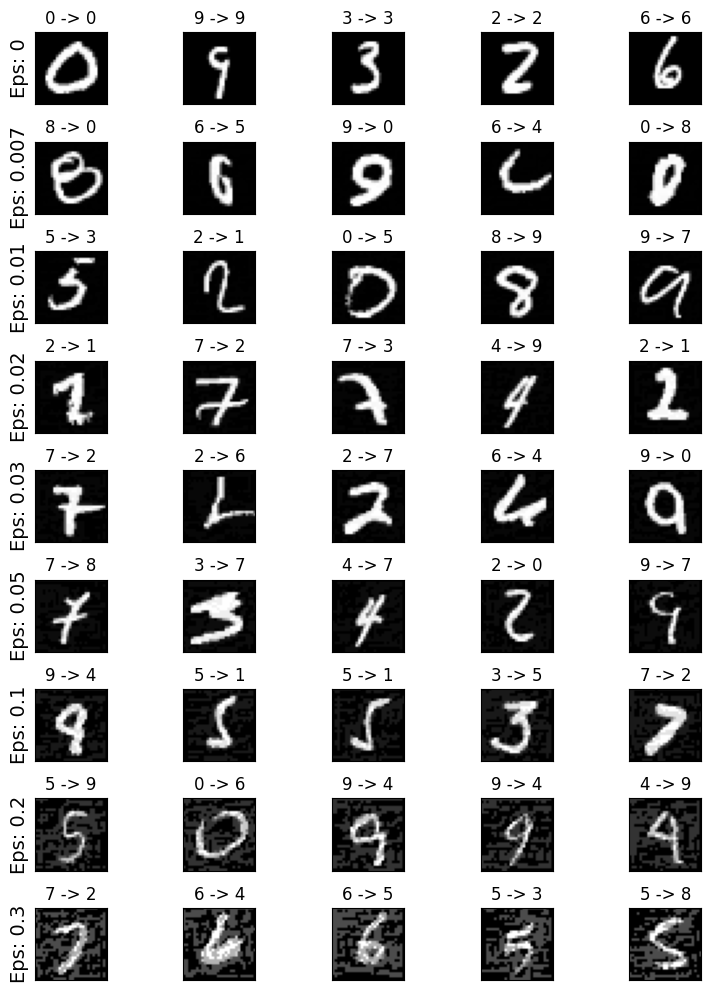

Epsilon: 0	Test Accuracy = 9835 / 10000 = 0.9835
Epsilon: 0.007	Test Accuracy = 9818 / 10000 = 0.9818
Epsilon: 0.01	Test Accuracy = 9793 / 10000 = 0.9793
Epsilon: 0.02	Test Accuracy = 9766 / 10000 = 0.9766
Epsilon: 0.03	Test Accuracy = 9693 / 10000 = 0.9693
Epsilon: 0.05	Test Accuracy = 9489 / 10000 = 0.9489
Epsilon: 0.1	Test Accuracy = 8362 / 10000 = 0.8362
Epsilon: 0.2	Test Accuracy = 3303 / 10000 = 0.3303
Epsilon: 0.3	Test Accuracy = 1415 / 10000 = 0.1415


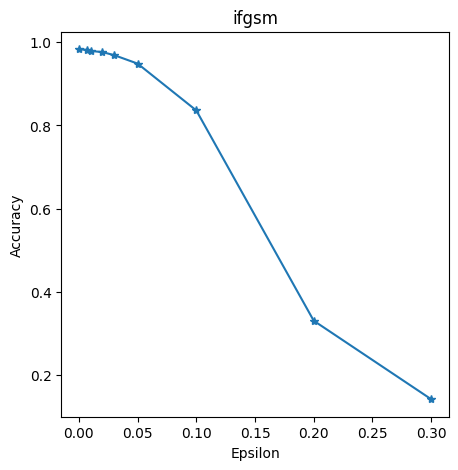

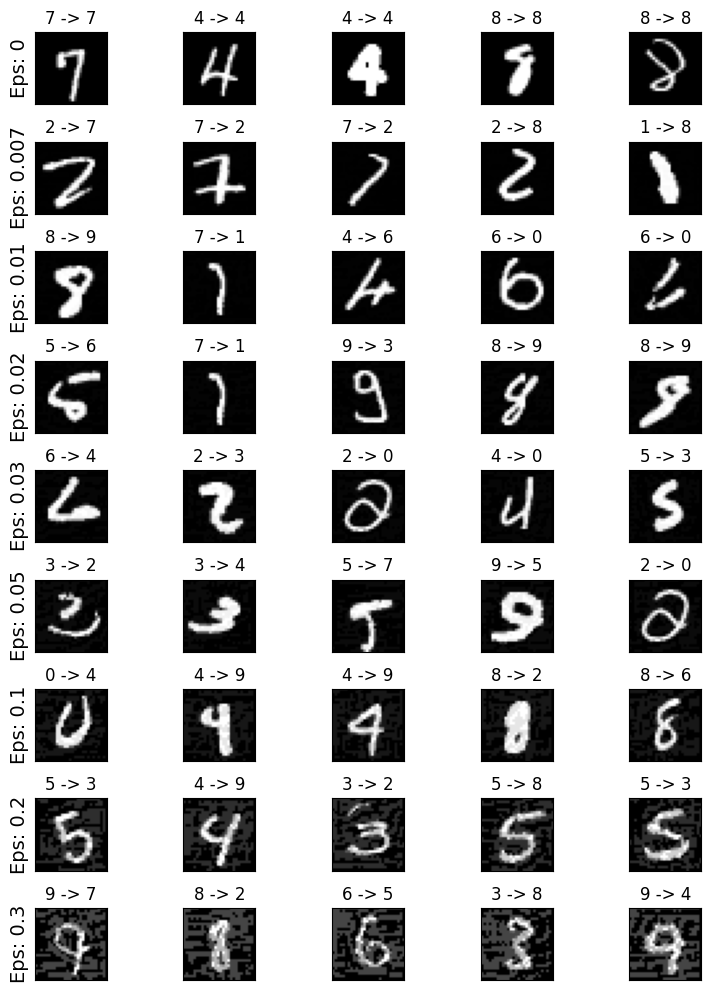

Epsilon: 0	Test Accuracy = 9832 / 10000 = 0.9832
Epsilon: 0.007	Test Accuracy = 9822 / 10000 = 0.9822
Epsilon: 0.01	Test Accuracy = 9807 / 10000 = 0.9807
Epsilon: 0.02	Test Accuracy = 9750 / 10000 = 0.975
Epsilon: 0.03	Test Accuracy = 9695 / 10000 = 0.9695
Epsilon: 0.05	Test Accuracy = 9504 / 10000 = 0.9504
Epsilon: 0.1	Test Accuracy = 8369 / 10000 = 0.8369
Epsilon: 0.2	Test Accuracy = 3178 / 10000 = 0.3178
Epsilon: 0.3	Test Accuracy = 1367 / 10000 = 0.1367


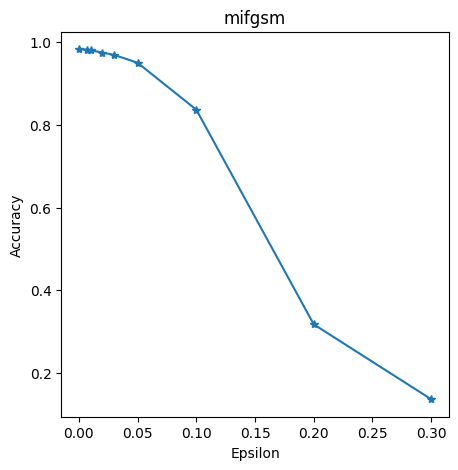

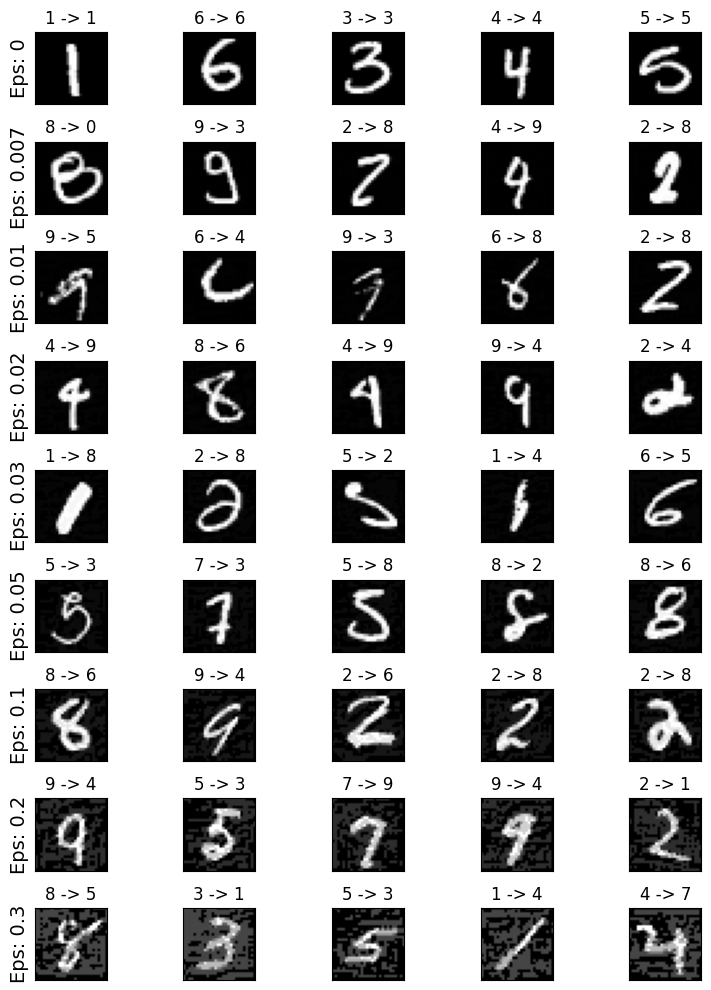

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

##Defense

In [ ]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [ ]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)

    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 0.391259504626242 Val_Loss: 0.28454208486838173
Epoch: 2 Loss: 0.22059055100580346 Val_Loss: 0.17749040849119113
Epoch: 3 Loss: 0.13716464752604196 Val_Loss: 0.12347471036747418
Epoch: 4 Loss: 0.10231491897101562 Val_Loss: 0.10414110036460404
Epoch: 5 Loss: 0.08680445869358358 Val_Loss: 0.09358930134480986
Epoch: 6 Loss: 0.07684863630911552 Val_Loss: 0.0853938148908733
Epoch: 7 Loss: 0.06944959567031411 Val_Loss: 0.081716879329787
Epoch: 8 Loss: 0.06486772797885809 Val_Loss: 0.0768118379461059
Epoch: 9 Loss: 0.06039209183314967 Val_Loss: 0.07429612929657296
Epoch: 10 Loss: 0.05562138716871983 Val_Loss: 0.07246904966681375


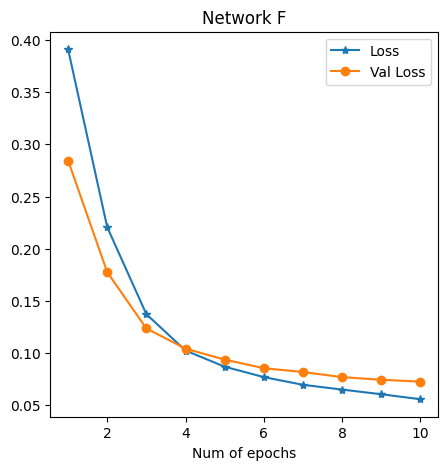

Fitting the model...
Epoch: 1 Loss: 0.4253669651051546 Val_Loss: 0.3186568175681075
Epoch: 2 Loss: 0.2899933240713079 Val_Loss: 0.2802825463382203
Epoch: 3 Loss: 0.22893472081747565 Val_Loss: 0.2172294687521588
Epoch: 4 Loss: 0.18053425176184565 Val_Loss: 0.1717908260728606
Epoch: 5 Loss: 0.14765331071331772 Val_Loss: 0.15339711843478357
Epoch: 6 Loss: 0.12634123894003332 Val_Loss: 0.13649794339936847
Epoch: 7 Loss: 0.11305800493636514 Val_Loss: 0.12174515173315634
Epoch: 8 Loss: 0.10253652538521582 Val_Loss: 0.11704081168184793
Epoch: 9 Loss: 0.09441961818537646 Val_Loss: 0.1143822989331763
Epoch: 10 Loss: 0.0880464953305437 Val_Loss: 0.10535283424743375


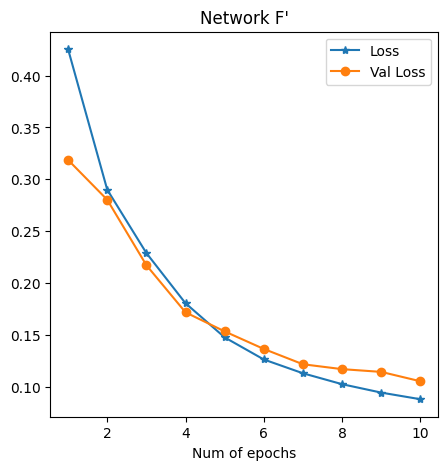

Epsilon: 0	Test Accuracy = 9655 / 10000 = 0.9655
Epsilon: 0.007	Test Accuracy = 9661 / 10000 = 0.9661
Epsilon: 0.01	Test Accuracy = 9639 / 10000 = 0.9639
Epsilon: 0.02	Test Accuracy = 9637 / 10000 = 0.9637
Epsilon: 0.03	Test Accuracy = 9626 / 10000 = 0.9626
Epsilon: 0.05	Test Accuracy = 9600 / 10000 = 0.96
Epsilon: 0.1	Test Accuracy = 9585 / 10000 = 0.9585
Epsilon: 0.2	Test Accuracy = 9571 / 10000 = 0.9571
Epsilon: 0.3	Test Accuracy = 9586 / 10000 = 0.9586


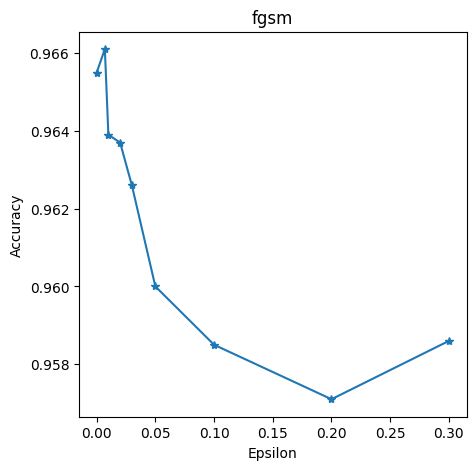

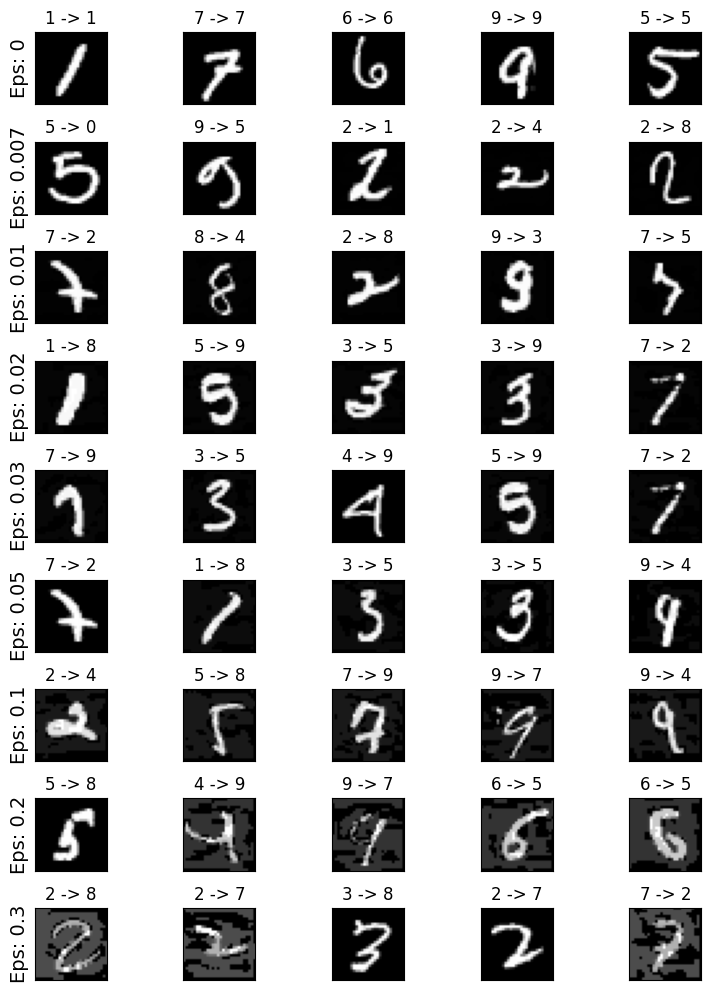

Epsilon: 0	Test Accuracy = 9661 / 10000 = 0.9661
Epsilon: 0.007	Test Accuracy = 9669 / 10000 = 0.9669
Epsilon: 0.01	Test Accuracy = 9642 / 10000 = 0.9642
Epsilon: 0.02	Test Accuracy = 9618 / 10000 = 0.9618
Epsilon: 0.03	Test Accuracy = 9598 / 10000 = 0.9598
Epsilon: 0.05	Test Accuracy = 9587 / 10000 = 0.9587
Epsilon: 0.1	Test Accuracy = 9564 / 10000 = 0.9564
Epsilon: 0.2	Test Accuracy = 9557 / 10000 = 0.9557
Epsilon: 0.3	Test Accuracy = 9572 / 10000 = 0.9572


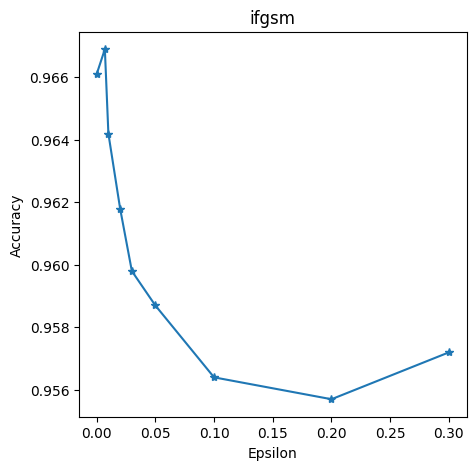

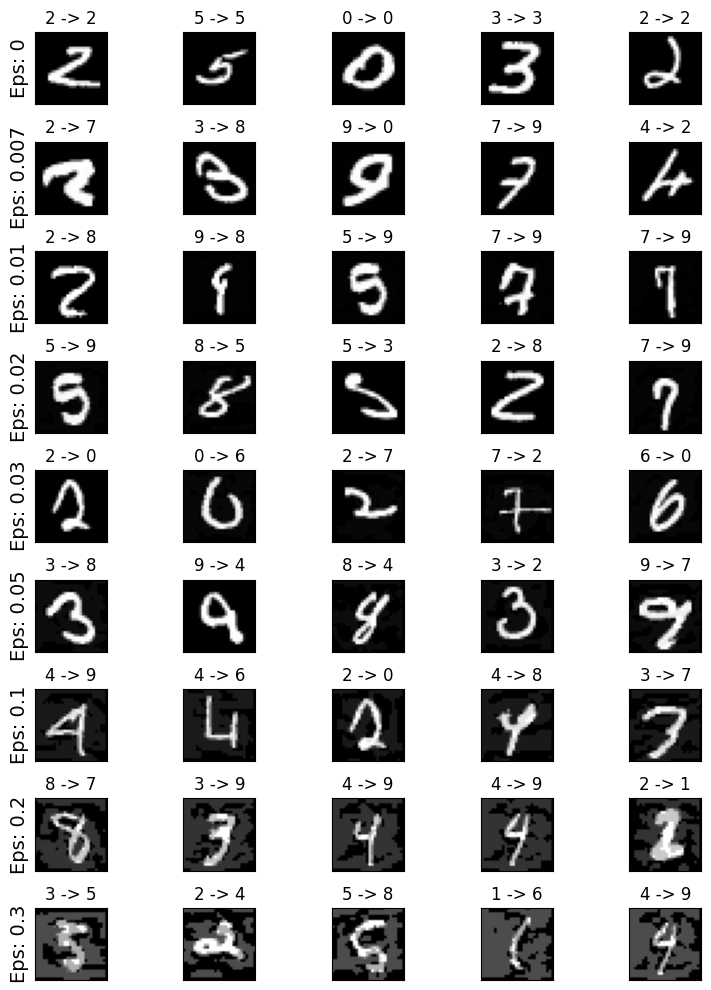

Epsilon: 0	Test Accuracy = 9667 / 10000 = 0.9667
Epsilon: 0.007	Test Accuracy = 9642 / 10000 = 0.9642
Epsilon: 0.01	Test Accuracy = 9652 / 10000 = 0.9652
Epsilon: 0.02	Test Accuracy = 9615 / 10000 = 0.9615
Epsilon: 0.03	Test Accuracy = 9622 / 10000 = 0.9622
Epsilon: 0.05	Test Accuracy = 9594 / 10000 = 0.9594
Epsilon: 0.1	Test Accuracy = 9583 / 10000 = 0.9583
Epsilon: 0.2	Test Accuracy = 9570 / 10000 = 0.957
Epsilon: 0.3	Test Accuracy = 9586 / 10000 = 0.9586


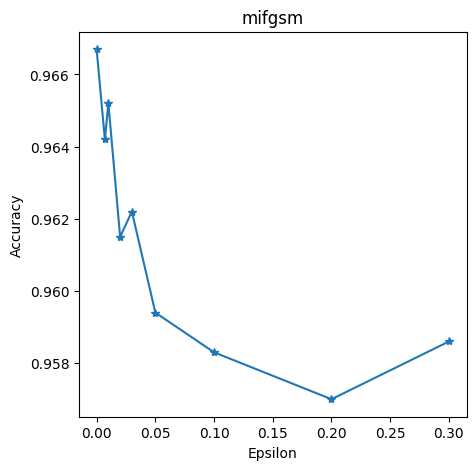

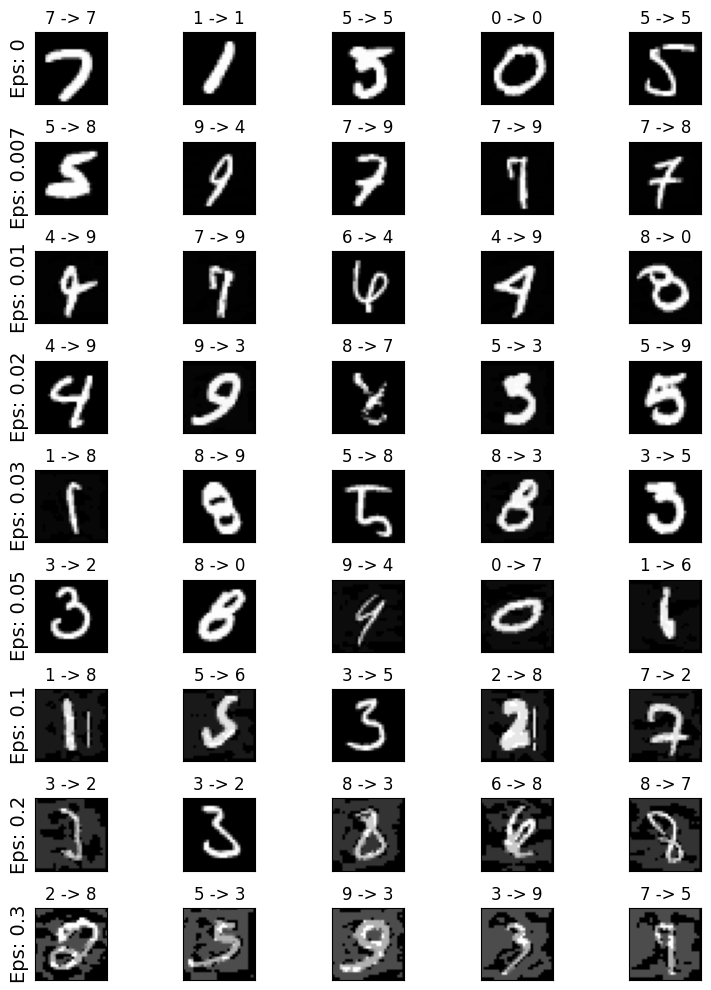

In [ ]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)